# Tensorflow and Keras model
## Imports and version check

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.ops.numpy_ops import np_config
from datetime import datetime
from sklearn.preprocessing import StandardScaler

np_config.enable_numpy_behavior()

print(tf.__version__)
print(tf.test.is_built_with_cuda())

2.6.0
True


## Configuration of GPU and plots

In [4]:
plt.style.use("ggplot")
np.set_printoptions(precision=3, suppress=True)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read CSV file

In [89]:
# current_path = os.path.dirname(os.path.realpath(__file__))
current_path = os.path.abspath('')
training_data_path = os.path.abspath(
    os.path.join(current_path, '..', '..', 'data', 'TRAINING_DATA_CYCLE_LENGTHS_AS_FEATURES.csv'))
csv_data = pd.read_csv(training_data_path)

# csv_data.iloc[:, 32:103]
csv_dataset = csv_data.copy()
csv_data.head()

,1,2,3,4,5,6,7,8,9,10,...,keff64,keff65,keff66,keff67,keff68,keff69,ppf_start,ppf_max,ppf_end,cycle_length_in_days
0,505.236340,391.189251,507.876623,347.487252,391.189251,549.372403,391.189251,188.446900,535.587659,535.587659,...,0.945909,0.944285,0.942662,0.941040,0.939418,0.937797,4.433,5.608,1.381,411.474034
1,535.587659,323.596645,323.596645,488.564011,488.564011,488.564011,188.446900,347.487252,535.587659,507.876623,...,0.952956,0.951327,0.949698,0.948070,0.946443,0.944816,2.690,2.690,1.320,432.732046
2,323.596645,507.876623,535.587659,505.236340,323.596645,549.372403,488.564011,391.189251,535.587659,505.236340,...,0.951664,0.950032,0.948401,0.946772,0.945143,0.943517,4.269,5.356,1.324,429.459459
3,323.596645,507.876623,391.189251,535.587659,188.446900,549.372403,188.446900,535.587659,323.596645,323.596645,...,0.947787,0.946196,0.944604,0.943012,0.941420,0.939828,5.760,7.038,1.422,409.351467
4,507.876623,488.564011,488.564011,488.564011,323.596645,535.587659,507.876623,323.596645,488.564011,488.564011,...,0.947005,0.945420,0.943835,0.942251,0.940666,0.939082,2.572,2.572,1.424,408.764331


## Changing keff to rho (reactivity)

In [91]:
csv_dataset.iloc[:, 32:103] = (csv_data.iloc[:, 32:103] - 1) / csv_data.iloc[:, 32:103]
csv_dataset.iloc[:, 32:103]

,keff_start,keff_max,keff1,keff2,keff3,keff4,keff5,keff6,keff7,keff8,...,keff60,keff61,keff62,keff63,keff64,keff65,keff66,keff67,keff68,keff69
0,0.131287,0.140377,0.131287,0.140377,0.123705,0.110486,0.100744,0.093016,0.086491,0.080687,...,-0.049967,-0.051764,-0.053565,-0.055371,-0.057184,-0.059002,-0.060826,-0.062654,-0.064489,-0.066329
1,0.111730,0.113075,0.111730,0.113075,0.109477,0.105344,0.100520,0.095595,0.090771,0.086071,...,-0.042234,-0.044009,-0.045789,-0.047575,-0.049366,-0.051163,-0.052966,-0.054774,-0.056588,-0.058407
2,0.117553,0.125709,0.117553,0.125709,0.115688,0.106603,0.099731,0.094056,0.088993,0.084276,...,-0.043626,-0.045409,-0.047197,-0.048991,-0.050791,-0.052596,-0.054406,-0.056221,-0.058041,-0.059864
3,0.116841,0.128442,0.116841,0.128442,0.109738,0.094936,0.085084,0.078066,0.072659,0.068102,...,-0.048052,-0.049800,-0.051556,-0.053319,-0.055089,-0.056863,-0.058645,-0.060432,-0.062225,-0.064024
4,0.082071,0.083332,0.082071,0.083332,0.083124,0.082061,0.079797,0.077119,0.074240,0.071123,...,-0.048934,-0.050683,-0.052437,-0.054196,-0.055961,-0.057731,-0.059507,-0.061288,-0.063077,-0.064870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.112239,0.113473,0.112239,0.113473,0.110285,0.107176,0.103359,0.099325,0.095303,0.091326,...,-0.039301,-0.041140,-0.042981,-0.044829,-0.046682,-0.048539,-0.050400,-0.052266,-0.054137,-0.056013
9996,0.133653,0.136647,0.133653,0.136647,0.131776,0.126371,0.120661,0.115058,0.109614,0.104314,...,-0.026447,-0.028180,-0.029920,-0.031666,-0.033418,-0.035176,-0.036942,-0.038714,-0.040493,-0.042278
9997,0.116894,0.119124,0.116894,0.119124,0.114721,0.109806,0.104488,0.099282,0.094299,0.089494,...,-0.043230,-0.045050,-0.046875,-0.048704,-0.050540,-0.052381,-0.054228,-0.056081,-0.057939,-0.059801
9998,0.107401,0.108623,0.107401,0.108623,0.105710,0.102683,0.098831,0.094730,0.090611,0.086529,...,-0.044236,-0.046064,-0.047897,-0.049737,-0.051581,-0.053432,-0.055288,-0.057147,-0.059011,-0.060883


## Split data into train and test

In [92]:
train_dataset = csv_dataset.sample(frac=0.8, random_state=0)
test_dataset = csv_dataset.drop(train_dataset.index)
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
1,8000.0,428.161767,114.771627,188.446900,347.487252,488.564011,507.876623,549.372403
2,8000.0,426.248704,115.914282,188.446900,347.487252,488.564011,507.876623,549.372403
3,8000.0,425.721939,114.656662,188.446900,347.487252,488.564011,507.876623,549.372403
4,8000.0,425.922168,115.161552,188.446900,347.487252,488.564011,507.876623,549.372403
5,8000.0,426.464525,115.320726,188.446900,347.487252,488.564011,507.876623,549.372403
...,...,...,...,...,...,...,...,...
keff69,8000.0,-0.060933,0.008602,-0.101519,-0.066657,-0.060678,-0.054914,-0.032740
ppf_start,8000.0,3.233506,0.787582,1.919000,2.721000,3.037000,3.496000,9.917000
ppf_max,8000.0,3.529833,1.259520,1.979000,2.722000,3.087000,3.879250,12.390000
ppf_end,8000.0,1.365294,0.047191,1.238000,1.332000,1.361000,1.394000,1.587000


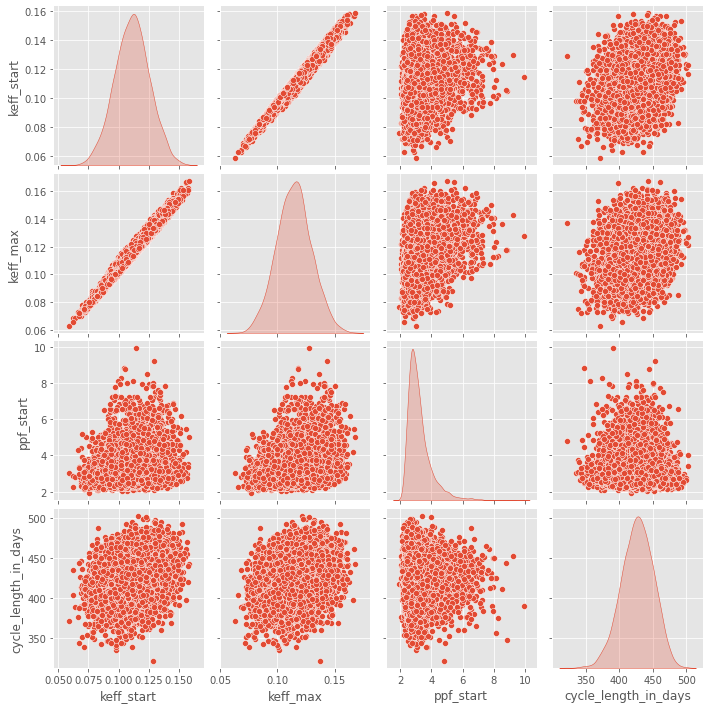

In [93]:
sns.pairplot(csv_dataset[['keff_start', 'keff_max', 'ppf_start', 'cycle_length_in_days']], diag_kind='kde')
# sns.pairplot(train_dataset[['ppf_start', 'ppf_max', 'ppf_end', 'cycle_length_in_days']], diag_kind='kde')

## Split features from labels
Separate target values from the values on which the neural network is being trained.

In [238]:
labels = ["keff_max", "keff1", "keff2", "keff3"] + \
         ["keff"+str(i) for i in range(4, 69, 2)] + \
         ["cycle_length_in_days"]

x_train = train_dataset.iloc[:, :32].values
y_train = train_dataset.get(labels).values
x_test = test_dataset.iloc[:, :32].values
y_test = test_dataset.get(labels).values

## Normalization
Normalization layer normalizes values along rows for input. For output StandardScaler class is used. Worth to mention
that np.append(first, second) only returns object with second appended to the first, doesn't change the original.

In [239]:
normalizer = layers.Normalization(axis=1, mean=None)
normalizer.adapt(x_train)
print("First row: {} \nNormalized: {}".format(x_train[0], normalizer(x_train[0])))

First row: [188.447 507.877 505.236 391.189 507.877 347.487 505.236 391.189 549.372
 347.487 391.189 535.588 507.877 507.877 535.588 507.877 347.487 507.877
 549.372 505.236 188.447 549.372 488.564 507.877 188.447 188.447 347.487
 391.189 488.564 549.372 505.236 347.487] 
Normalized: [[-2.089  0.704  0.694 -0.302  0.706 -0.699  0.683 -0.305  1.085 -0.683
  -0.312  0.957  0.728  0.719  0.964  0.721 -0.71   0.697  1.081  0.689
  -2.085  1.086  0.538  0.712 -2.052 -2.07  -0.679 -0.296  0.545  1.076
   0.686 -0.675]]


In [240]:
output_scaler = StandardScaler()
output_scaler.fit(np.append(y_train, y_test, axis=0))
y_train, y_test = output_scaler.transform(y_train), output_scaler.transform(y_test)

## Conversion of data to Tensors.
This is the last step before training the model.

In [241]:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)


# Model
## Layers
For the network with two hidden layers $NHN1 = m\cdot r^{2}$ and $NHN2 = m\cdot r$ where $r=(n\cdot m)^{1/3}$.  
$n$ - number of input neurons, $m$ - number of output neurons.

[Bohdan Macukow. Neural Networks – State of Art, BriefHistory, Basic Models and Architecture.]

| No. output neurons | r | NHN1 | NHN2 |
| --- | --- | --- | --- |
| 1 | x | 0 | x |
| 3 | 4.5788 | 62.8977 | 13.7365 |

In [242]:
weight_initializer = keras.initializers.glorot_uniform()

model = keras.Sequential([
    keras.Input(shape=(32,), name="input-features"),
    normalizer,
    layers.Dense(units=64,
                 activation=keras.activations.gelu,
                 kernel_initializer=weight_initializer),
    layers.Dropout(rate=0.15),
    layers.Dense(units=64,
                 activation=keras.activations.gelu,
                 kernel_initializer=weight_initializer),
    layers.Dropout(rate=0.15),
    layers.Dense(units=64,
                 activation=keras.activations.gelu,
                 kernel_initializer=weight_initializer),
    layers.Dense(units=len(labels), name="output")
])

model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 32)                65        
_________________________________________________________________
dense_83 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 38)              

## Compile
Compile methods takes few methods: optimizer, loss - defined loss function, metrics - which metrics should be used when
learning and callbacks - call of some function after each epoch.

In [243]:
model.compile(
    # default values for Adam : lr = 0.001, beta_1 = 0.9, beta_2 = 0.999
    optimizer=keras.optimizers.Adam(learning_rate=0.01,
                                    beta_1=0.9,
                                    beta_2=0.9),
    # optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.mean_squared_error,
    metrics=[keras.metrics.mean_squared_error]
             # keras.metrics.mean_absolute_error]
)

## Fit
Fit the model to the data. Callbacks are used after/before each epoch to change the parameters during fitness.

In [244]:
%%time
NUM_EPOCHS = 30
history = model.fit(
    x_train,
    y_train,
    epochs=NUM_EPOCHS,
    verbose=1,
    shuffle=True,
    batch_size=32,  # default 32
    validation_data=(x_test, y_test),
)

Epoch 1/30
250/250 [==============================] - 2s 6ms/step - loss: 0.3180 - mean_squared_error: 0.3180 - val_loss: 0.2479 - val_mean_squared_error: 0.2479

In [245]:
history.history.keys()
# history.history['mean_squared_error']

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

#### Plot loss and other parameters from history

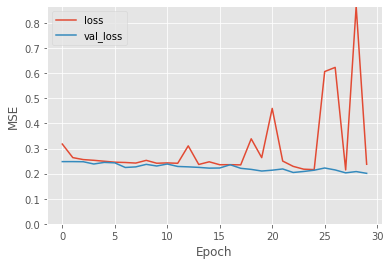

In [246]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, max(max(history.history['loss'][1:]), max(history.history['val_loss'][1:]))])
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss.svg')


plot_loss(history)

## Evaluation for each parameter

In [105]:
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

63/63 [==============================] - 0s 3ms/step - loss: 0.5905 - mean_squared_error: 0.5905 - mean_absolute_error: 0.5176
test loss, test acc: [0.5904863476753235, 0.5904863476753235, 0.517558217048645]


In [106]:
num_to_compare = 10
x_first_num, y_real = x_test[:num_to_compare].numpy(), y_test[:num_to_compare].numpy()
y_pred = model.predict(x_first_num)
output_scaler.inverse_transform(y_real)
y_real, y_pred = output_scaler.inverse_transform(y_real), output_scaler.inverse_transform(y_pred)

output_scaler.inverse_transform(y_real)
print("REAL\nPREDICTED")
for i, val_real in enumerate(y_real):
    print("====================================")
    print("{}\n{}".format(val_real, y_pred[i]))

REAL
PREDICTED
[ 1.708  1.653 -0.633]
[-0.389 -0.281 -0.566]
[-0.425 -0.91   0.544]
[ 0.133 -0.315  0.298]
[ 0.033 -0.273  0.319]
[ 0.113 -0.083  0.375]
[-0.835 -0.253 -1.135]
[-0.519 -0.234 -1.479]
[-0.912 -0.667 -0.267]
[-0.358 -0.162 -0.74 ]
[-0.358 -0.471 -1.08 ]
[-0.54  -0.255 -1.151]
[ 0.978 -0.435  0.074]
[-0.211 -0.098  0.143]
[-0.175 -0.282  1.142]
[0.686 0.338 1.071]
[-0.082 -0.53   1.717]
[ 0.419 -0.619  1.496]
[0.71  0.305 0.615]
[-0.062 -0.012  0.331]


# Hyperparameter tuning

In [41]:
current_path = os.path.dirname(os.path.realpath("__file__"))
data_path = os.path.abspath(os.path.join(current_path, '..', '..', 'data'))
today = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')

LOG_DIR = os.path.join(data_path, 'logs', 'hparam_tuning_' + today)

do_train_hyperparameters = True
if os.path.exists(LOG_DIR):
    print("--- Logs folder already exists! ---".upper())
    do_train_hyperparameters = False

In [53]:
from tensorboard.plugins.hparams import api as hp

HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([63, 120]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([14, 50]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.00001, 0.1))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))#, 'sgd']))
HP_ACTIVATION = hp.HParam('activation', hp.Discrete(["relu", "gelu", "softmax"]))

NUM_EPOCHS = 20
METRIC_ACCURACY = 'mean_squared_error'

with tf.summary.create_file_writer(os.path.join(LOG_DIR, 'config')).as_default():
  hp.hparams_config(
    # hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    hparams=[HP_NUM_UNITS_1, HP_NUM_UNITS_2, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='MSE')],
  )

In [54]:
weight_initializer = keras.initializers.glorot_uniform()

def train_test_model(run_dir, hparams):
    model = keras.Sequential([
        keras.Input(shape=(32,), name="input-features"),
        normalizer,
        layers.Dense(units=hparams[HP_NUM_UNITS_1],
                     activation=hparams[HP_ACTIVATION],
                     kernel_initializer=weight_initializer),
        # layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(units=hparams[HP_NUM_UNITS_2],
                     activation=hparams[HP_ACTIVATION],
                     kernel_initializer=weight_initializer),

        layers.Dense(units=len(labels), name="output")
    ])

    model.compile(
        optimizer=hparams[HP_OPTIMIZER],
        loss=keras.losses.mean_squared_error,
        metrics=[keras.metrics.mean_squared_error,
                 keras.metrics.mean_absolute_error]
    )

    model.fit(x_train, y_train, epochs=NUM_EPOCHS,
              validation_data=(x_test, y_test),
              callbacks=[
                  tf.keras.callbacks.TensorBoard(run_dir),  # log metrics
                  hp.KerasCallback(run_dir, hparams),  # log hparams
              ])

    _, mse, _ = model.evaluate(x_test, y_test)
    return mse


def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        mse = train_test_model(run_dir, hparams)
        # tf.summary.scalar(METRIC_ACCURACY, mse, step=1)

In [56]:
### FOR TWO LAYER NEURONS RESEARCH!
import sys
session_num = 0

if not do_train_hyperparameters:
    sys.exit(1)

# for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
for num_units_1 in HP_NUM_UNITS_1.domain.values:
    for num_units_2 in HP_NUM_UNITS_2.domain.values:
        for optimizer in HP_OPTIMIZER.domain.values:
            for activation in HP_ACTIVATION.domain.values:
                hparams = {
                  HP_NUM_UNITS_1: num_units_1,
                  # HP_DROPOUT: dropout_rate,
                  HP_NUM_UNITS_2: num_units_2,
                  HP_ACTIVATION: activation,
                  HP_OPTIMIZER: optimizer,
                }
                run_name = "run-{}-{}-{}-{}-{}".format(session_num, optimizer, num_units_1, num_units_2, activation)
                # run_name = "run-{}-{}-{}-{:.8f}".format(session_num, optimizer,num_units,dropout_rate)
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                run(os.path.join(LOG_DIR, run_name), hparams)
                session_num += 1



--- Starting trial: run-0-adam-63-14-gelu
{'num_units_1': 63, 'num_units_2': 14, 'activation': 'gelu', 'optimizer': 'adam'}
Epoch 1/20
250/250 [==============================] - 5s 15ms/step - loss: 0.8013 - mean_squared_error: 0.8013 - mean_absolute_error: 0.6562 - val_loss: 0.6482 - val_mean_squared_error: 0.6482 - val_mean_absolute_error: 0.5686

# Save results to file


In [247]:
x_first_num, y_real = x_test[:].numpy(), y_test[:].numpy()
y_pred = model.predict(x_first_num)
output_scaler.inverse_transform(y_real)
y_real, y_pred = output_scaler.inverse_transform(y_real), output_scaler.inverse_transform(y_pred)

# headers = ["keff_max_real", "ppf_max_real", "d_cycle_length_real", "keff_max_pred", "ppf_max_pred", "d_cycle_length_pred"]
headers_real = [label+"_real" for label in labels]
headers_pred = [label+"_pred" for label in labels]
headers = headers_real + headers_pred

pd.DataFrame(data=np.hstack([y_real, y_pred])).to_csv(os.path.join(data_path, 'prediction', 'prediction.csv'),
                                                      index=False, header=headers, sep='\t')

## Visualize results using TensorBoard
### Load the TensorBoard notebook extension
python -m tensorboard.main --logdir=logs/


In [ ]:
# import tensorboard as tb
# experiment_id = "u3fWtMznQpWBAGdFlbXRdg"
# experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
# df = experiment.get_scalars()
# df